In [1]:
from HARK.ConsumptionSaving.ConsIndBequestModel import (
    TerminalBequestConsumerType,
    init_lifecycle,
)

from HARK.Calibration.Income.IncomeTools import (
    parse_income_spec,
    parse_time_params,
    CGM_income,
)

from HARK.datasets.life_tables.us_ssa.SSATools import parse_ssa_life_table
from HARK.datasets.SCF.WealthIncomeDist.SCFDistTools import income_wealth_dists_from_scf
import matplotlib.pyplot as plt
import pandas as pd
from copy import copy

In [2]:
birth_age = 25
death_age = 90
adjust_infl_to = 1992
income_calib = CGM_income
education = "College"

# Income specification
income_params = parse_income_spec(
    age_min=birth_age,
    age_max=death_age,
    adjust_infl_to=adjust_infl_to,
    **income_calib[education],
    SabelhausSong=True
)

# Initial distribution of wealth and permanent income
dist_params = income_wealth_dists_from_scf(
    base_year=adjust_infl_to, age=birth_age, education=education, wave=1995
)

# We need survival probabilities only up to death_age-1, because survival
# probability at death_age is 1.
liv_prb = parse_ssa_life_table(
    female=True, cross_sec=True, year=2004, min_age=birth_age, max_age=death_age - 1
)

# Parameters related to the number of periods implied by the calibration
time_params = parse_time_params(age_birth=birth_age, age_death=death_age)

# Update all the new parameters
params = copy(init_lifecycle)
params.update(time_params)
params.update(dist_params)
params.update(income_params)
params.update({"LivPrb": liv_prb})

In [3]:
Agent = TerminalBequestConsumerType(**params)
Agent.solve()

In [4]:
# Number of agents and periods in the simulation.
Agent.AgentCount = 500
Agent.T_sim = 200

# Set up the variables we want to keep track of.
Agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "mNrm"]

# Run the simulations
Agent.initialize_sim()
Agent.simulate()

{'aNrm': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'cNrm': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'pLvl': array([[ 44.17755524,  20.35577683,   9.62156414, ...,  22.58783801,
           8.69202078,  11.39484156],
        [ 42.69570423,  17.65771873,  15.2555234 , ...,  29.27932939,
          13.78168087,   8.1685812 ],
        [ 54.99138173,  15.21967918,  13.14916017, ...,  37.71130629,
           9.81667739,   7.84428065],
        ...,
        [168.67772028, 332.10427744, 629.7416812 , ..., 121.36453854,

In [5]:
raw_data = {
    "Age": Agent.history["t_age"].flatten() + birth_age - 1,
    "pIncome": Agent.history["pLvl"].flatten(),
    "nrmM": Agent.history["mNrm"].flatten(),
    "nrmC": Agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

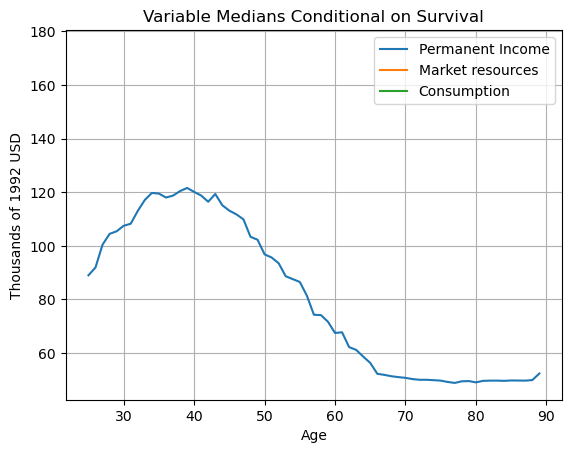

In [6]:
# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).median().reset_index()

plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Permanent Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Thousands of {} USD".format(adjust_infl_to))
plt.title("Variable Medians Conditional on Survival")
plt.grid()